In [1]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [10]:
df = loader()

In [3]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

def fit_knn(samples, targets, k):
    model = KNeighborsRegressor(n_neighbors=k).fit(samples, targets)
    return model

def forecast_knn(model, samples):
    predictions = model.predict(samples)
    return predictions

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    train /= std

    test -= mean
    test /= std
    return train, test

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)


In [5]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [9]:
def experiment(repeats, data, key):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    for r in range(repeats):
        forest_model = fit_knn(X_train, y_train, r+1)

        predictions = forecast_knn(forest_model, X_test)
        true = y_test
    
        # report performance
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        plotPredictions(key, true, predictions)
    return error_scores

(1419, 1)
1) Test MSE: 0.605
2) Test MSE: 0.485
3) Test MSE: 0.468
4) Test MSE: 0.435
5) Test MSE: 0.432
6) Test MSE: 0.436
7) Test MSE: 0.440
8) Test MSE: 0.437
9) Test MSE: 0.435
10) Test MSE: 0.442
(1419, 5)
1) Test MSE: 12.628
2) Test MSE: 10.205
3) Test MSE: 10.764
4) Test MSE: 11.859
5) Test MSE: 12.936
6) Test MSE: 13.014
7) Test MSE: 12.986
8) Test MSE: 12.604
9) Test MSE: 12.319
10) Test MSE: 12.249
(1419, 9)
1) Test MSE: 11.621
2) Test MSE: 10.287
3) Test MSE: 10.203
4) Test MSE: 9.842
5) Test MSE: 11.160
6) Test MSE: 11.520
7) Test MSE: 11.972
8) Test MSE: 12.260
9) Test MSE: 12.354
10) Test MSE: 12.486
(1419, 18)
1) Test MSE: 9.394
2) Test MSE: 8.295
3) Test MSE: 9.172
4) Test MSE: 10.628
5) Test MSE: 12.586
6) Test MSE: 13.497
7) Test MSE: 14.264
8) Test MSE: 15.149
9) Test MSE: 15.922
10) Test MSE: 16.173
(1433, 1)
1) Test MSE: 0.458
2) Test MSE: 0.349
3) Test MSE: 0.270
4) Test MSE: 0.264
5) Test MSE: 0.264
6) Test MSE: 0.263
7) Test MSE: 0.235
8) Test MSE: 0.232
9) Test

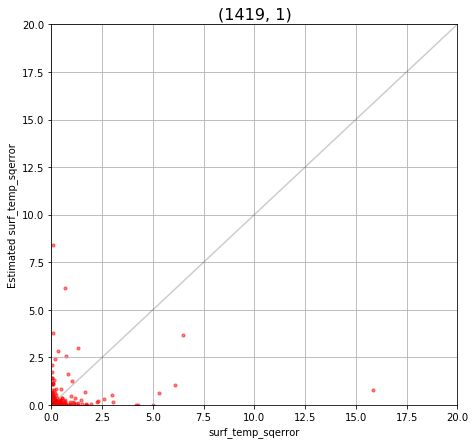

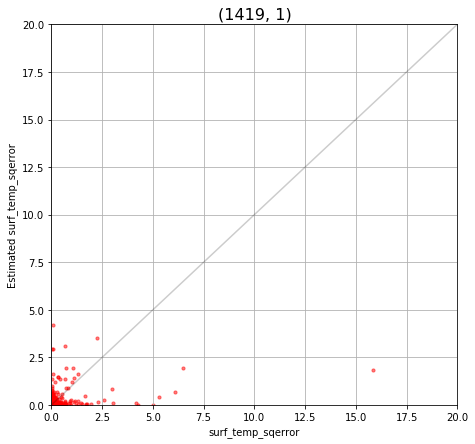

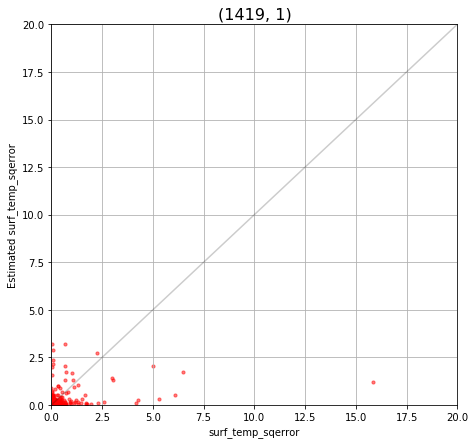

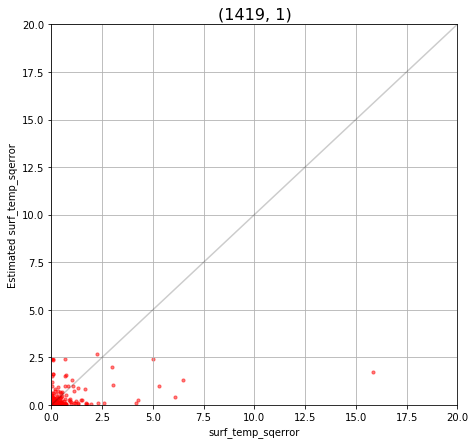

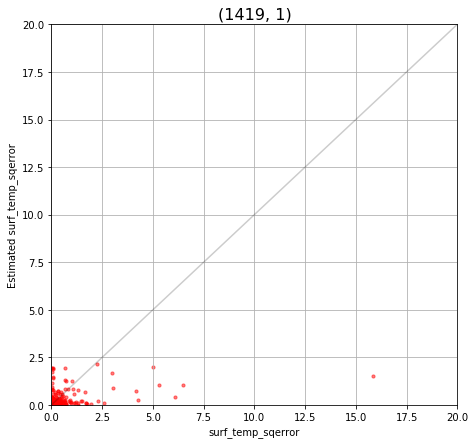

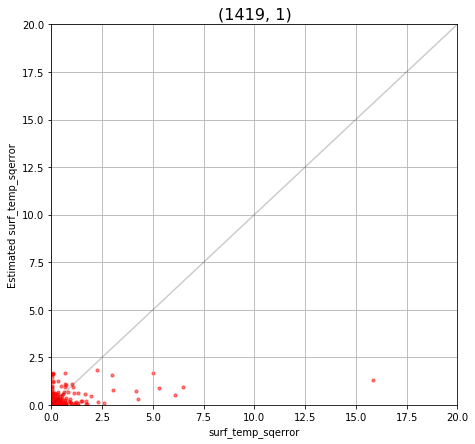

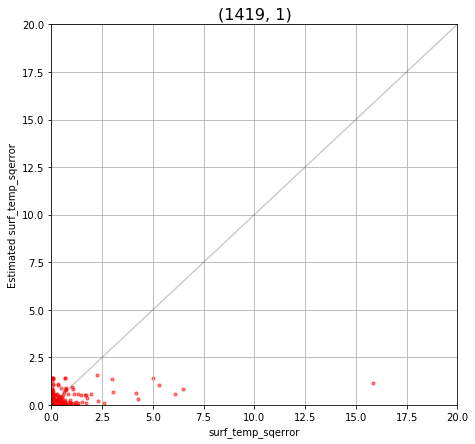

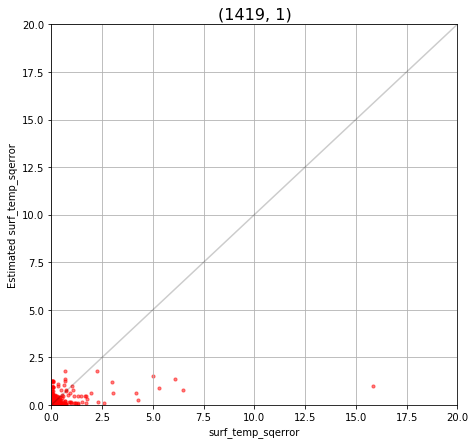

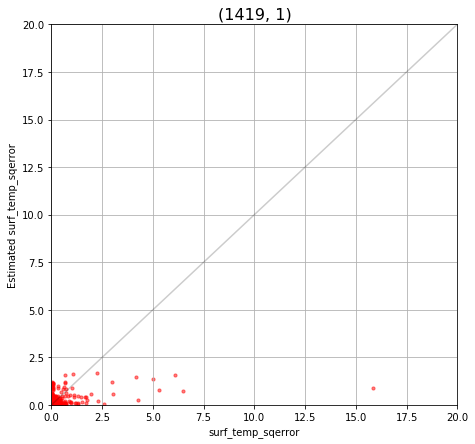

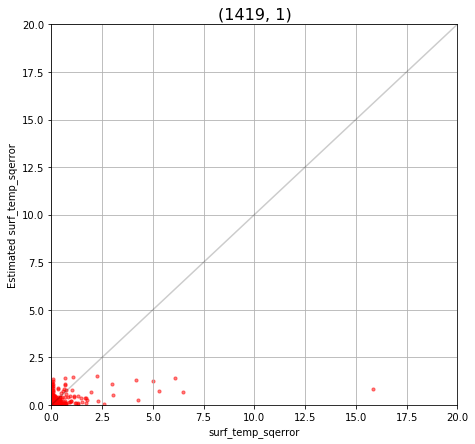

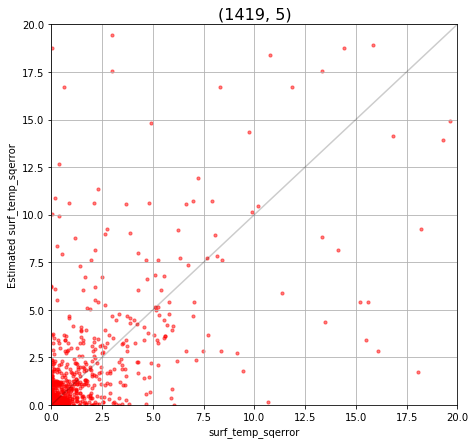

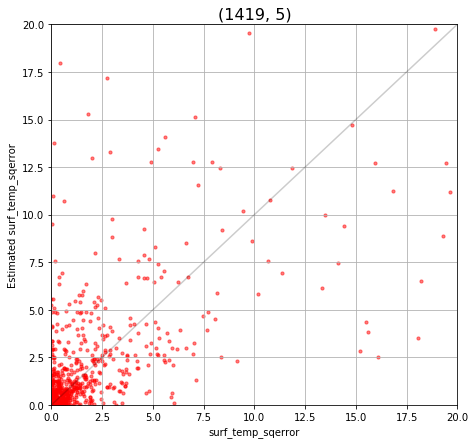

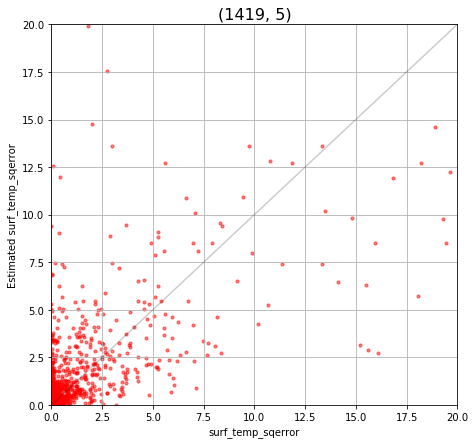

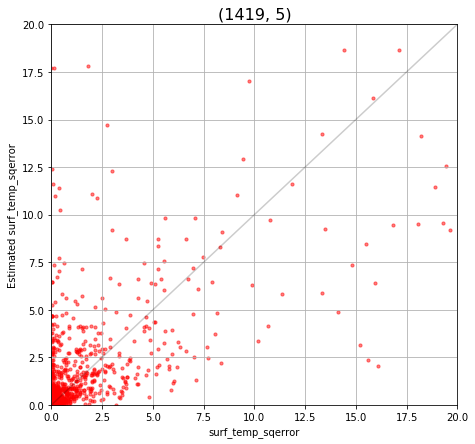

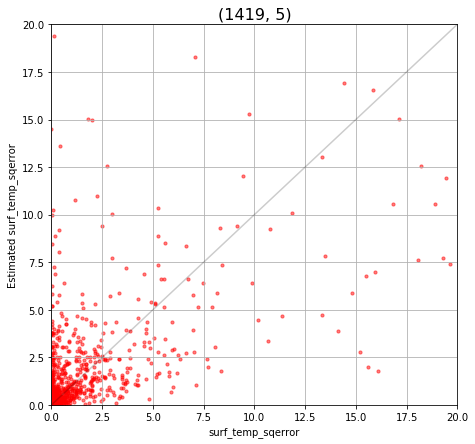

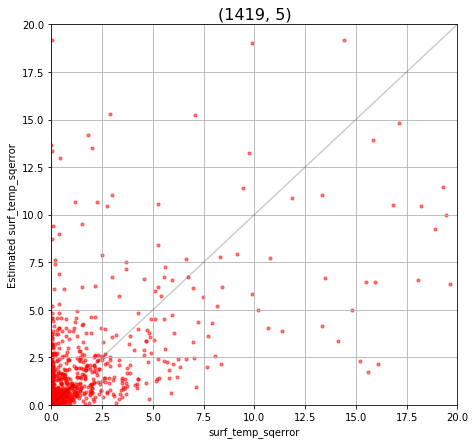

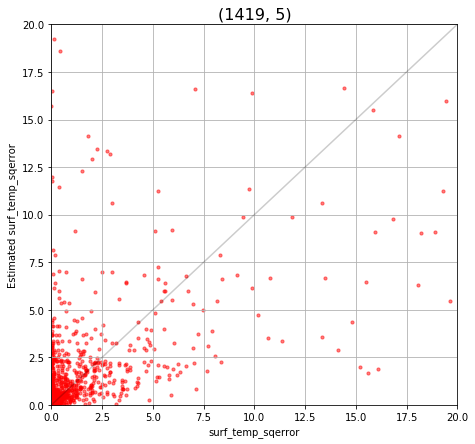

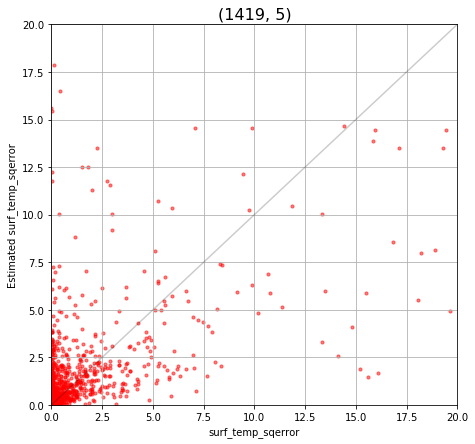

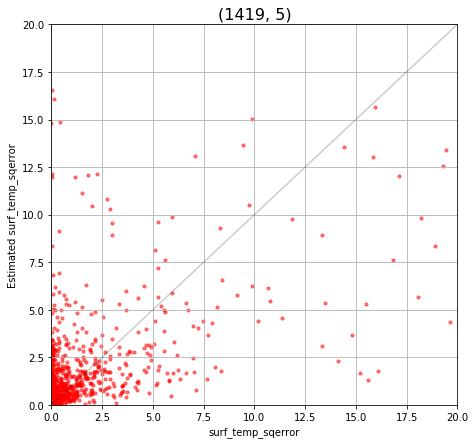

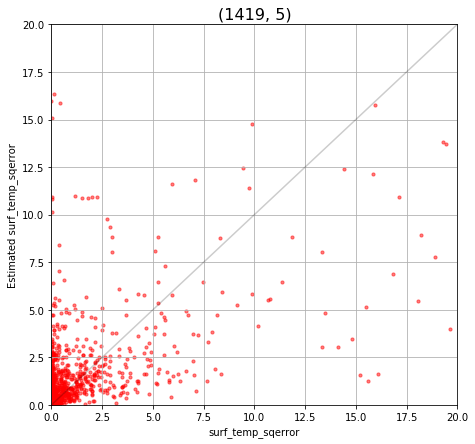

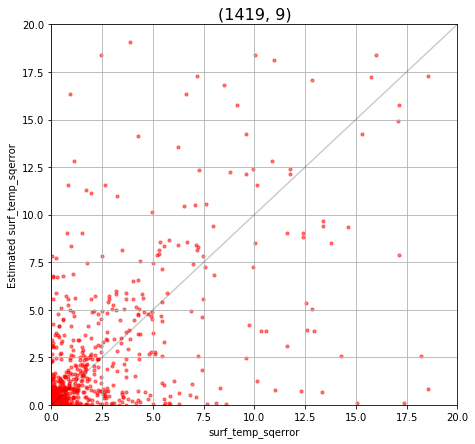

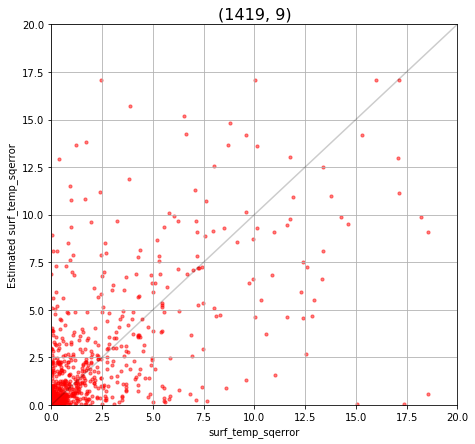

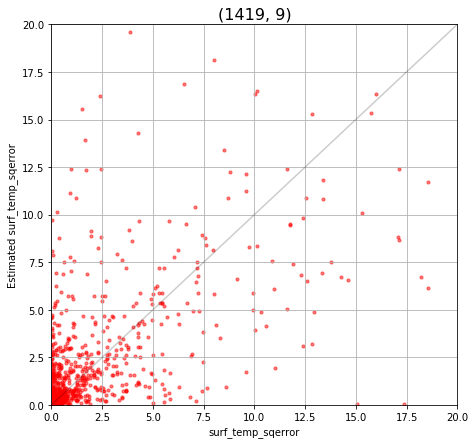

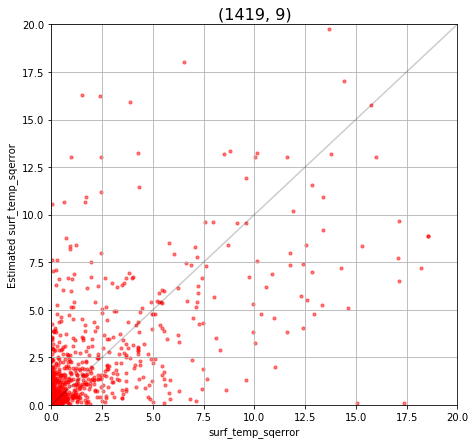

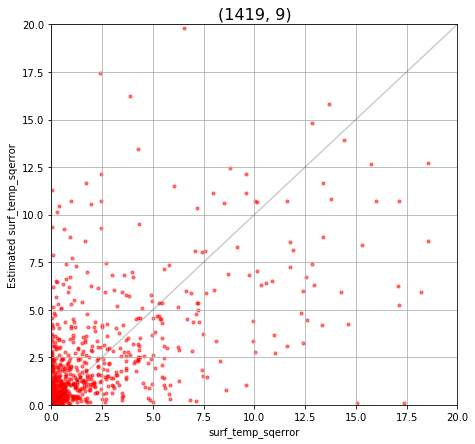

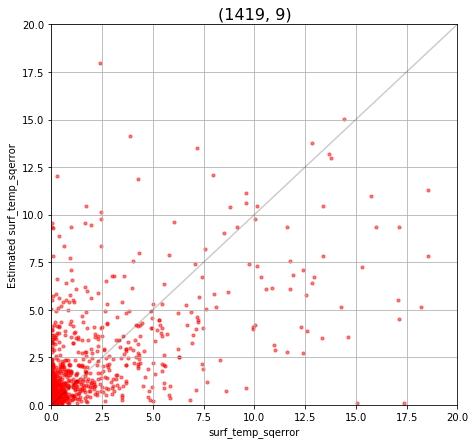

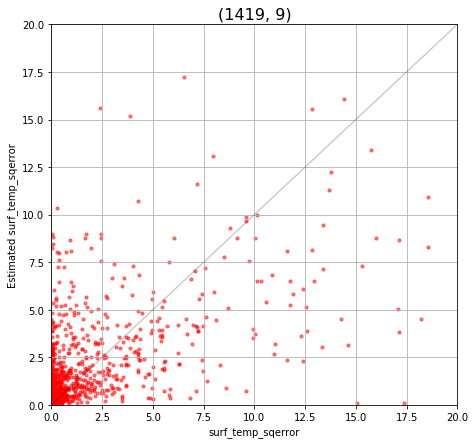

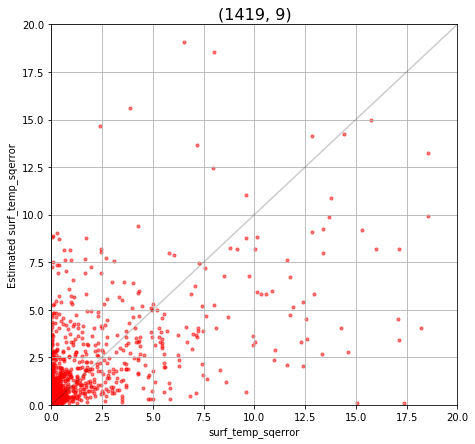

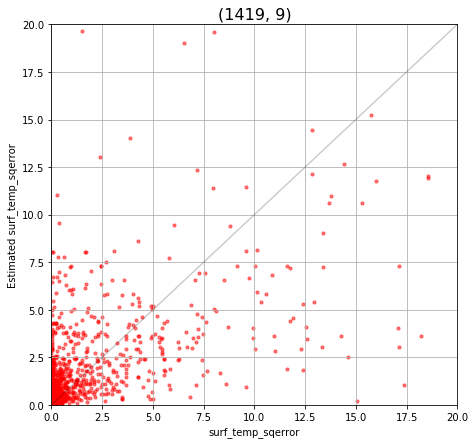

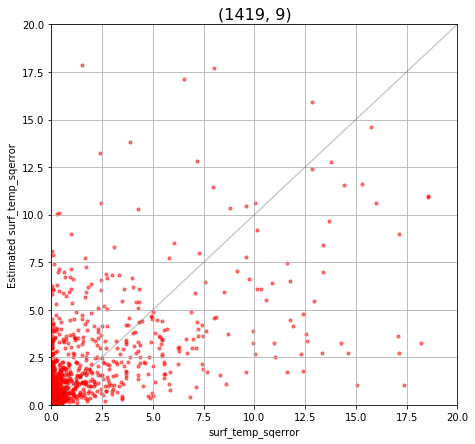

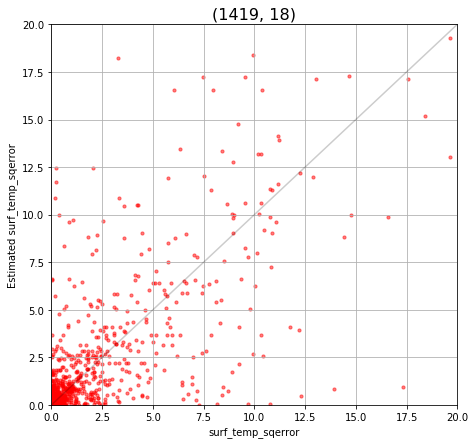

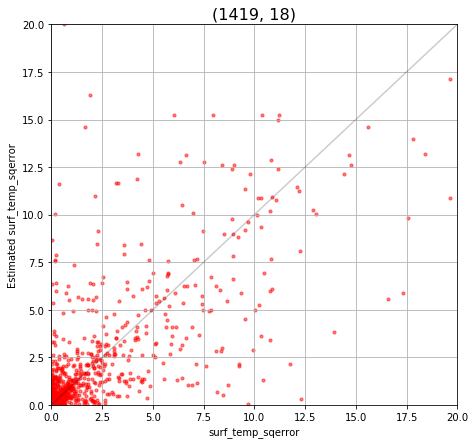

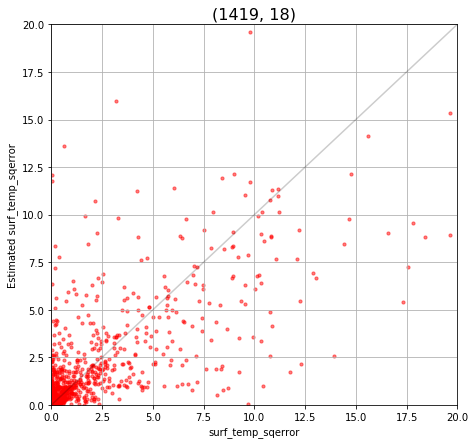

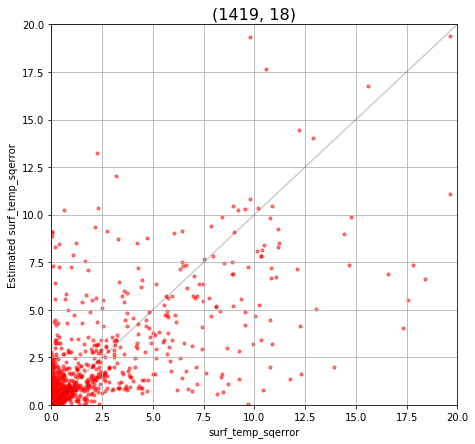

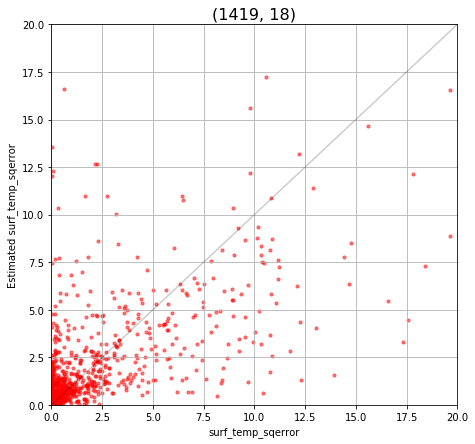

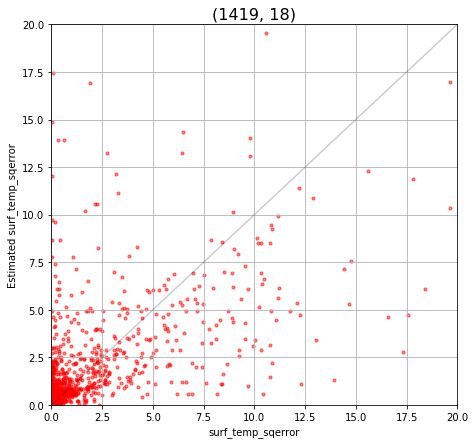

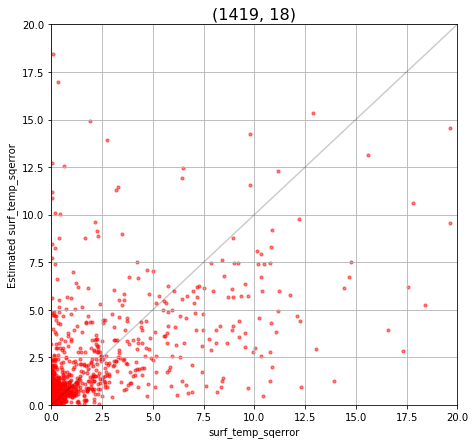

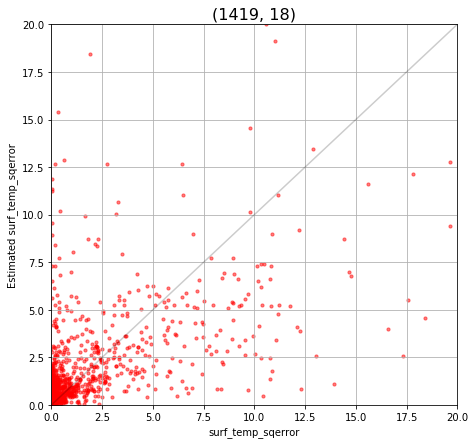

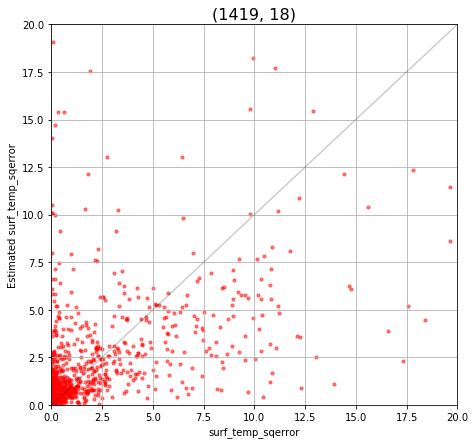

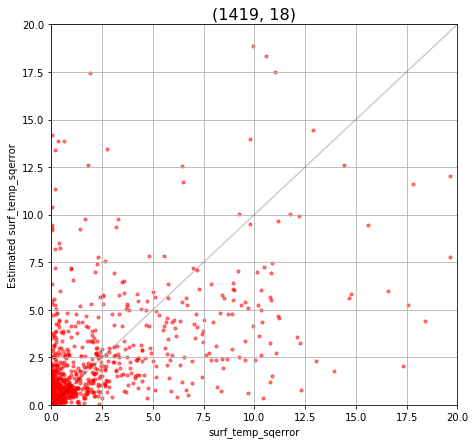

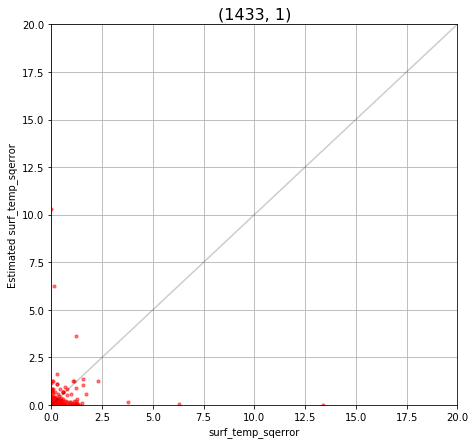

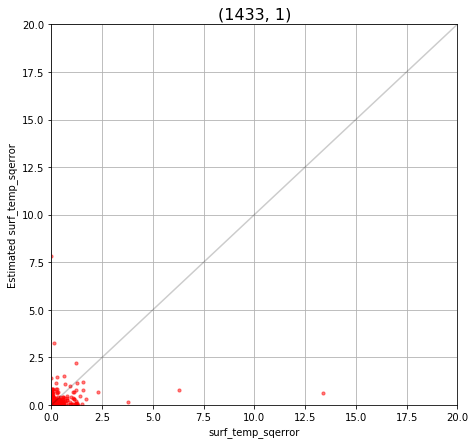

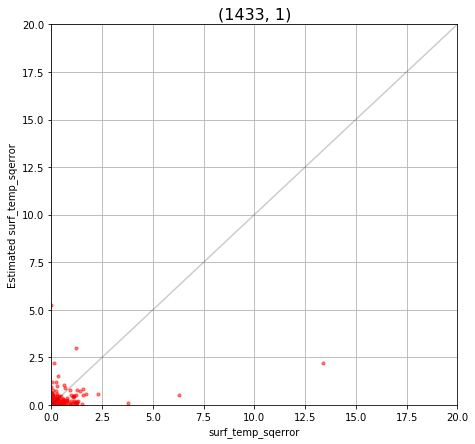

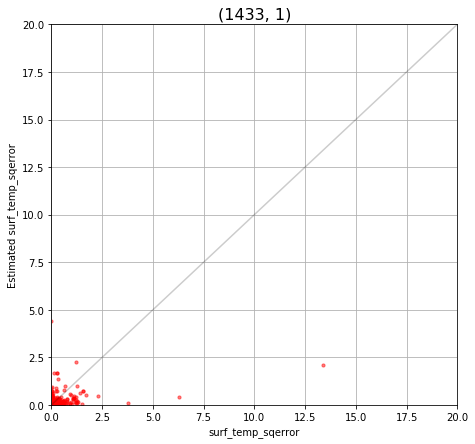

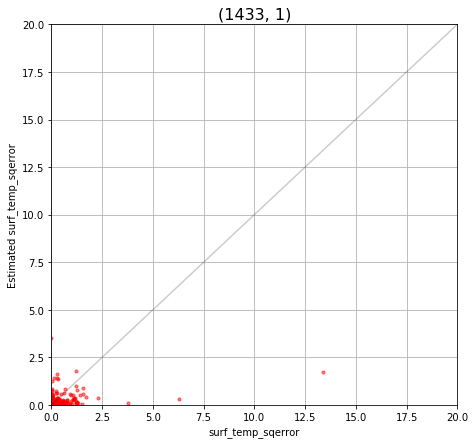

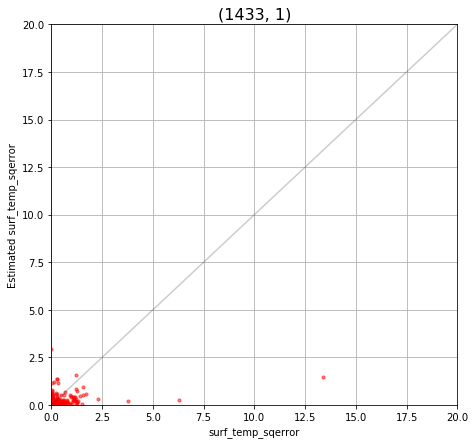

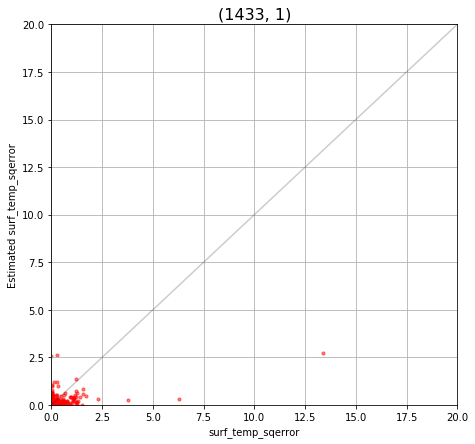

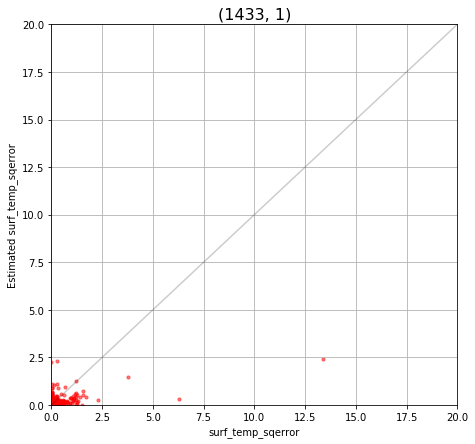

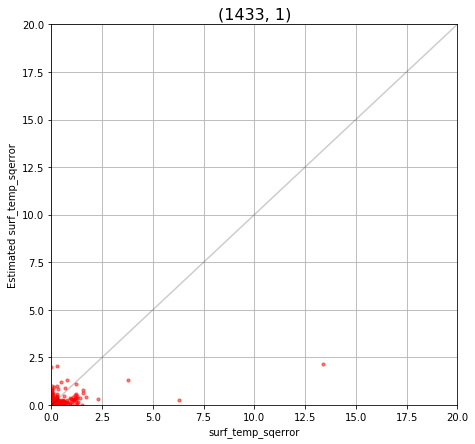

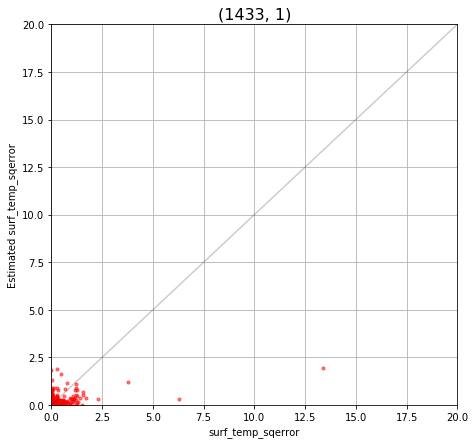

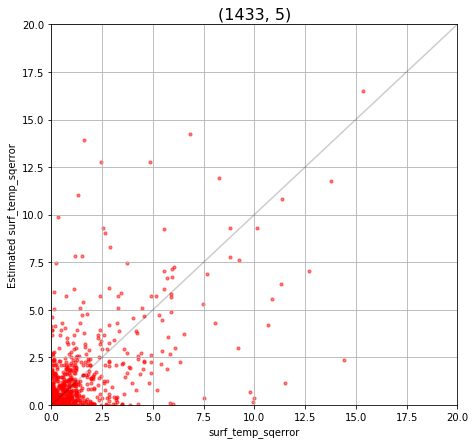

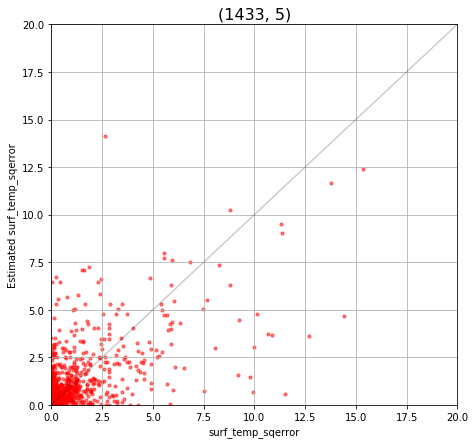

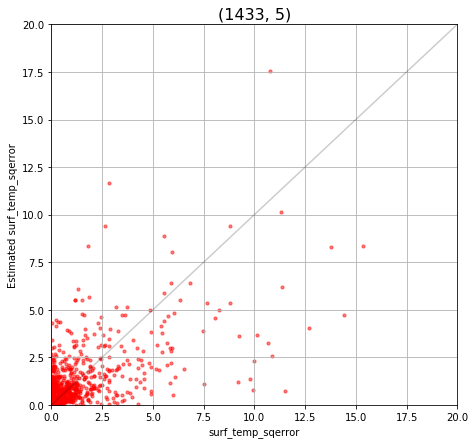

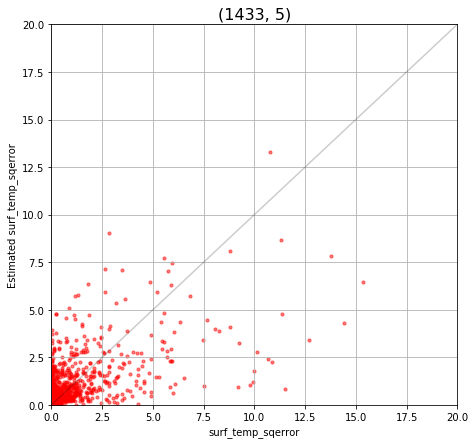

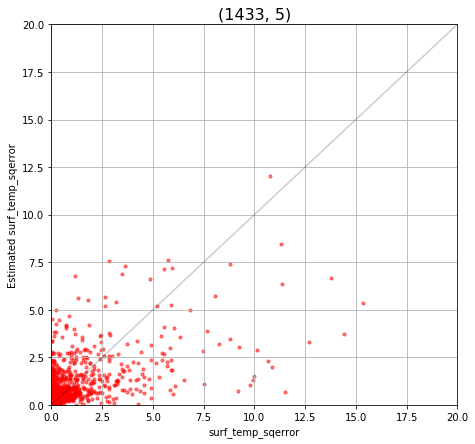

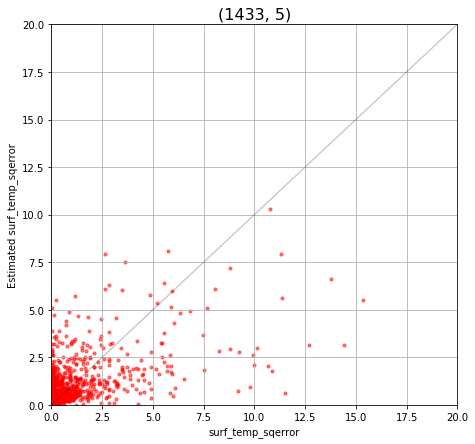

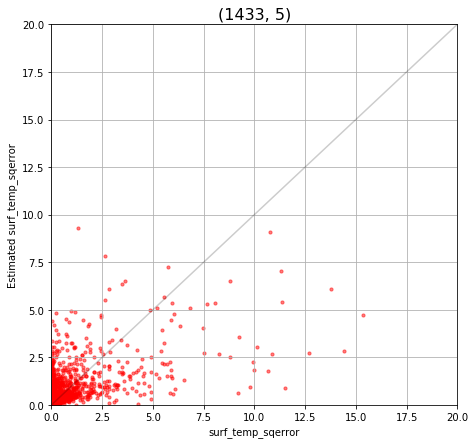

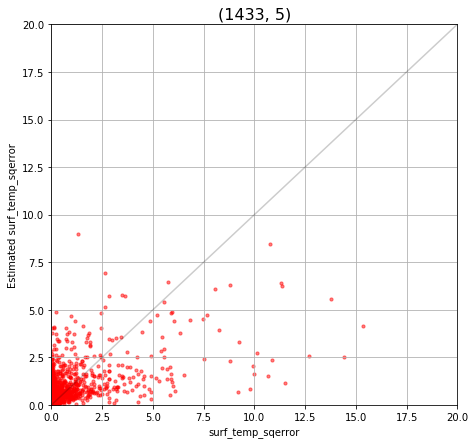

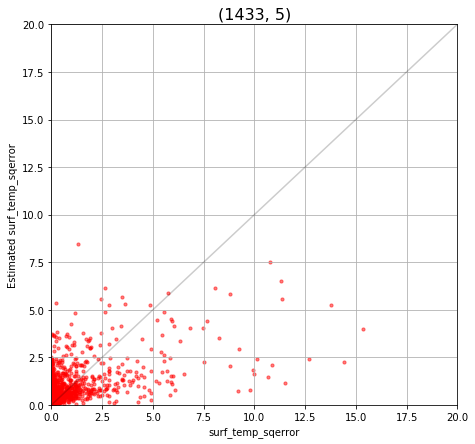

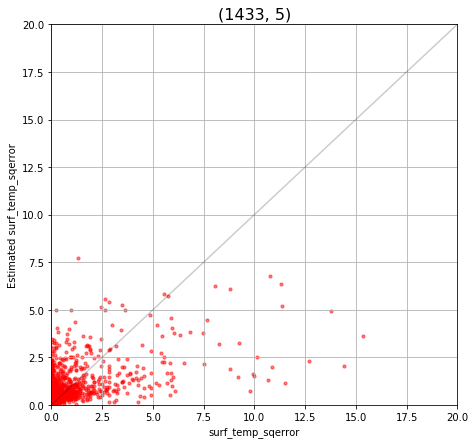

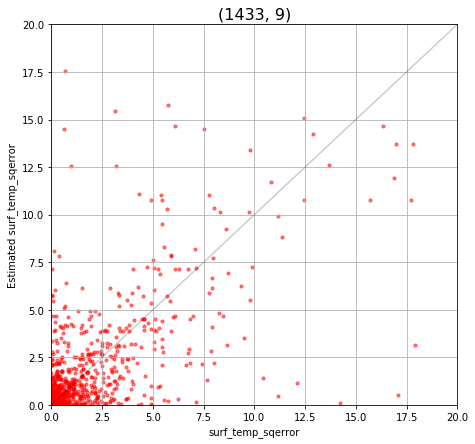

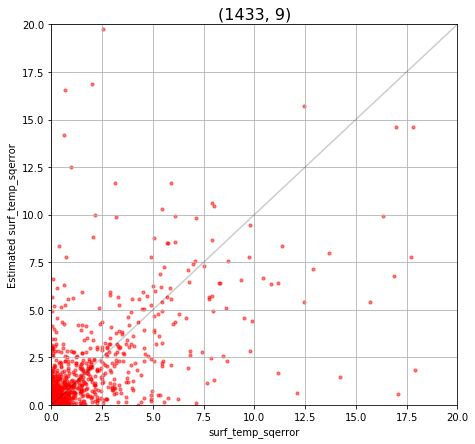

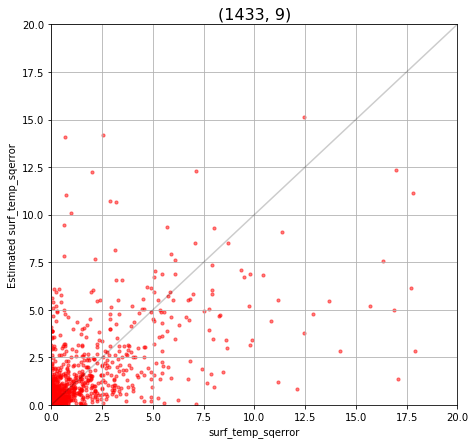

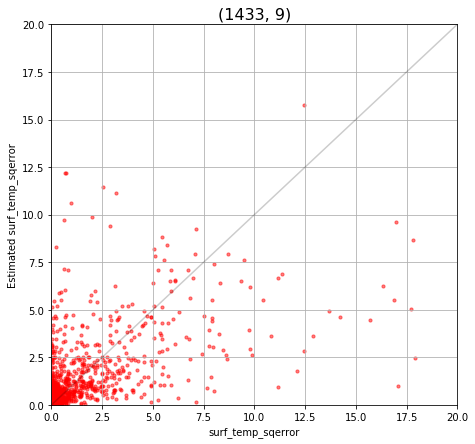

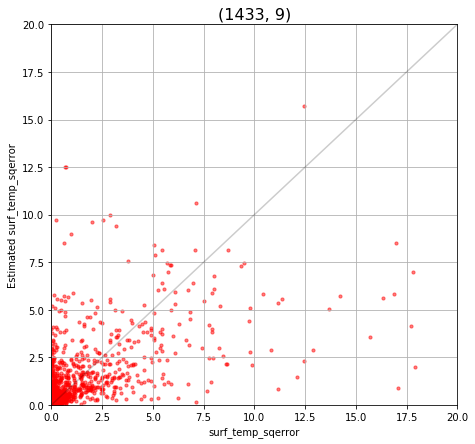

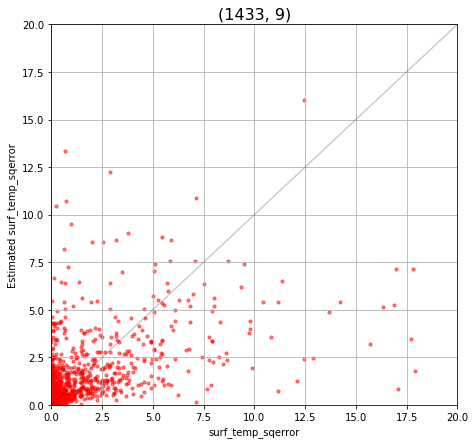

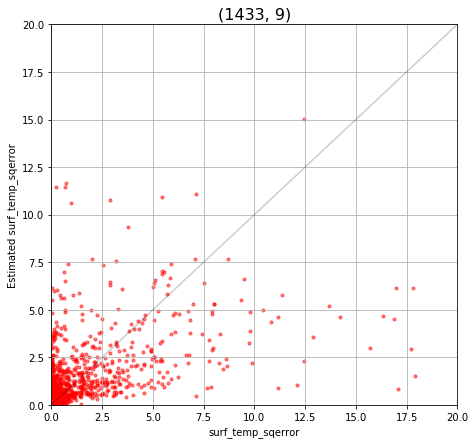

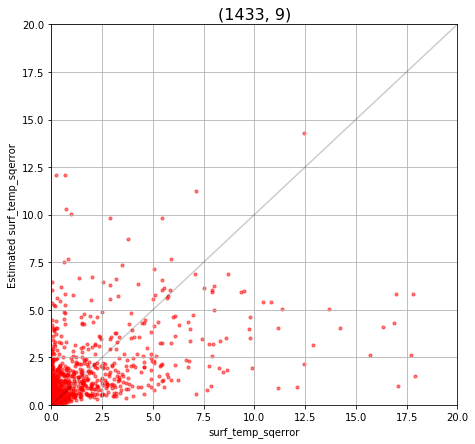

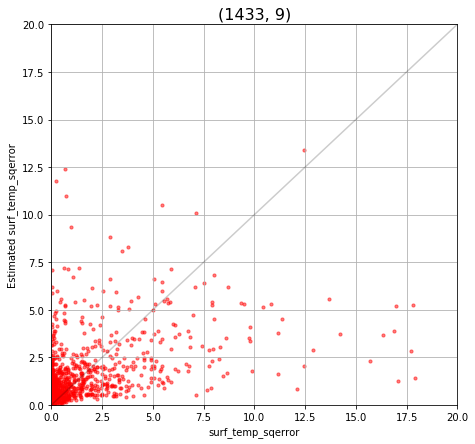

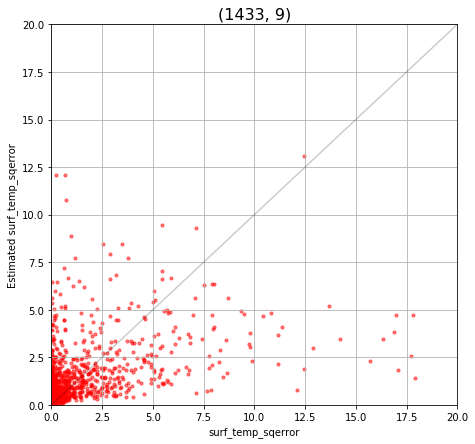

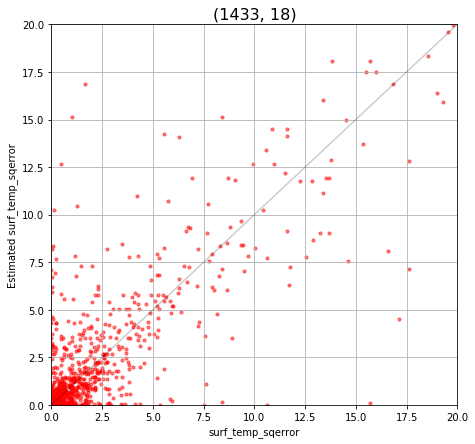

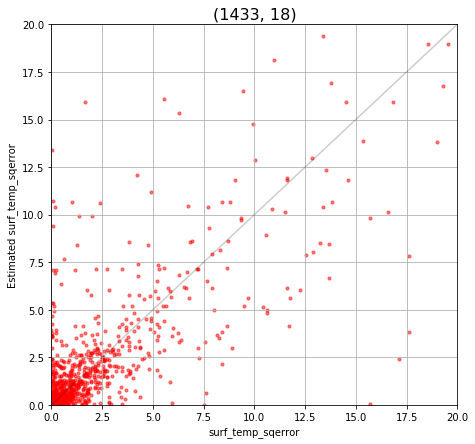

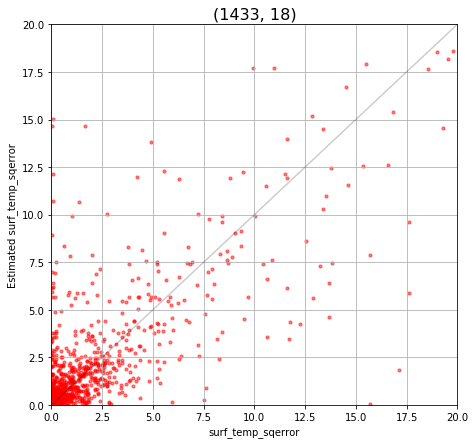

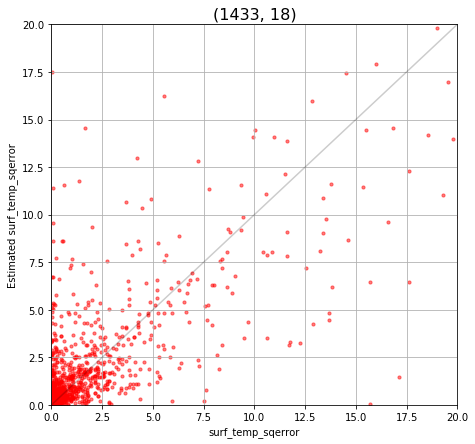

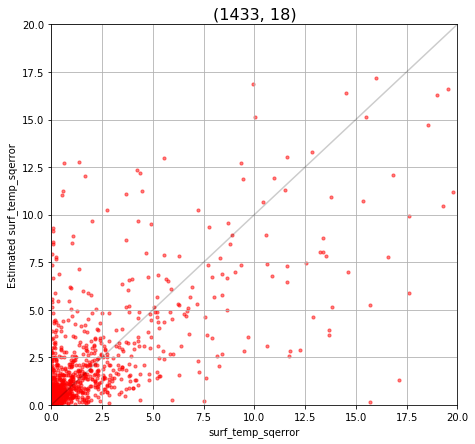

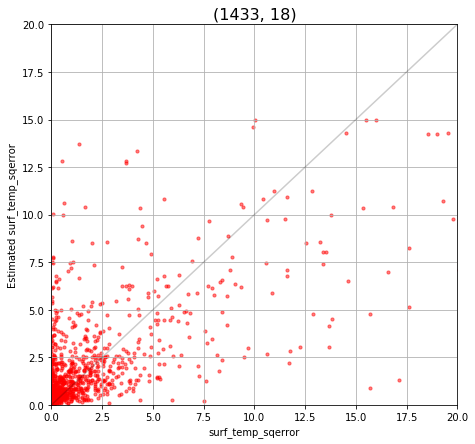

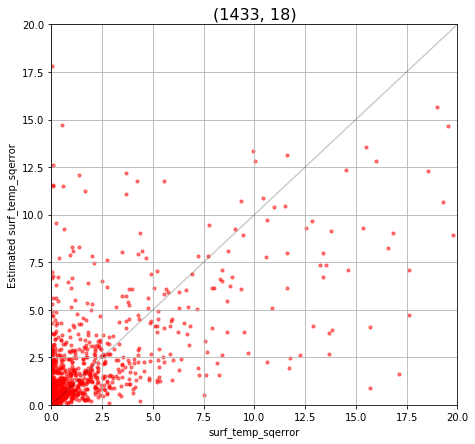

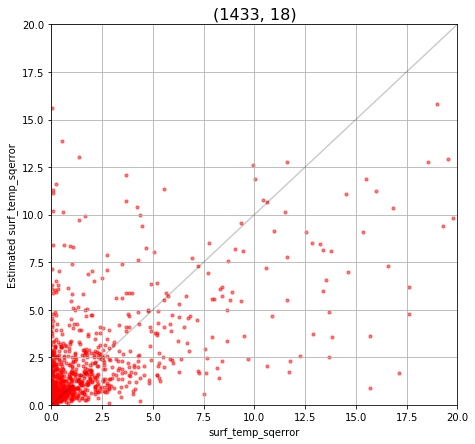

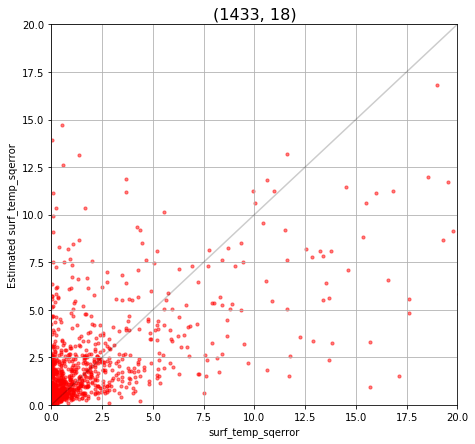

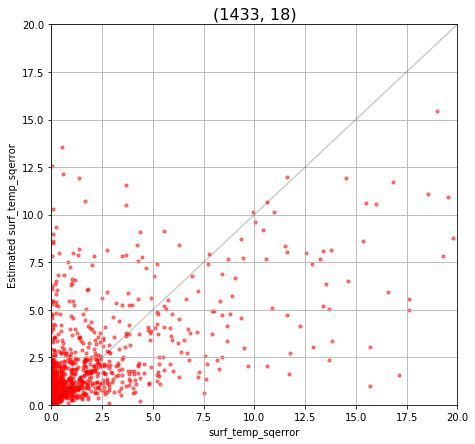

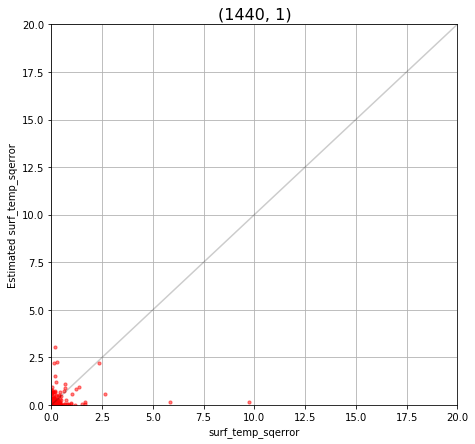

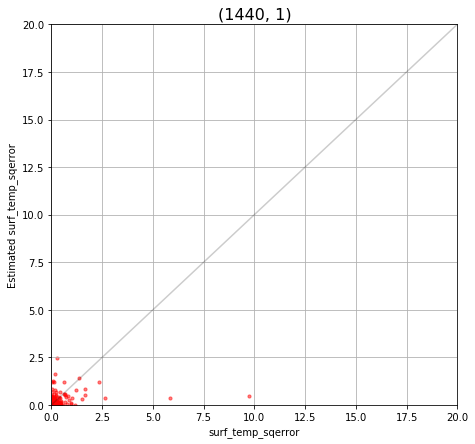

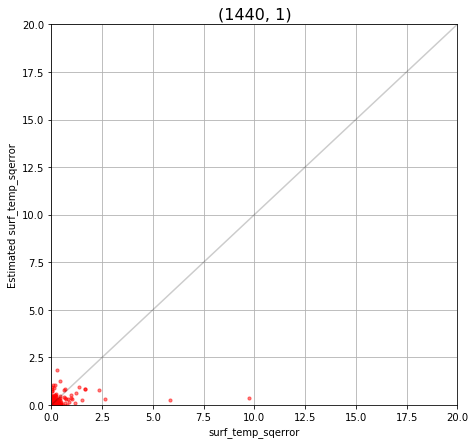

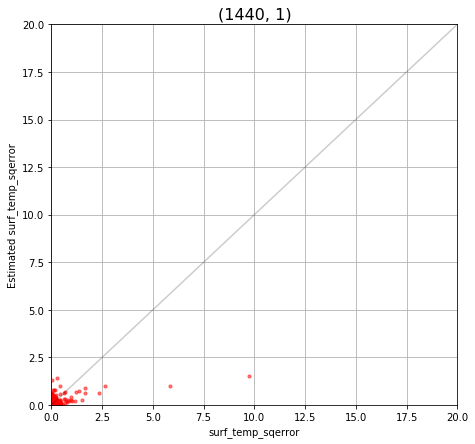

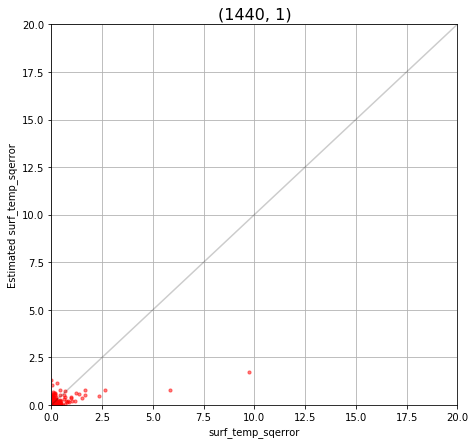

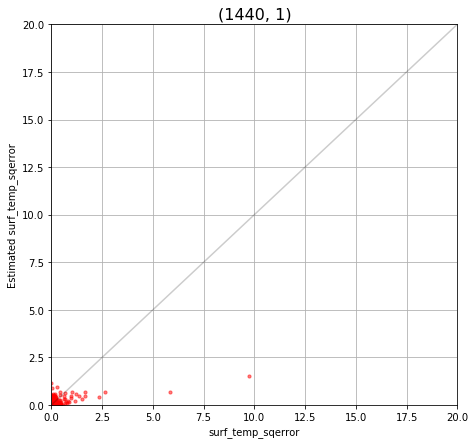

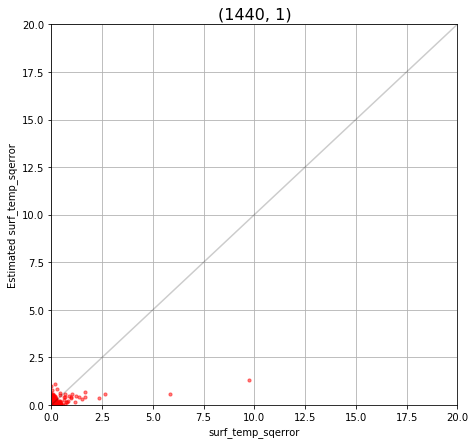

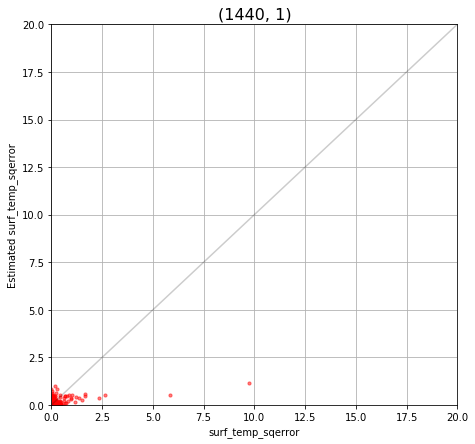

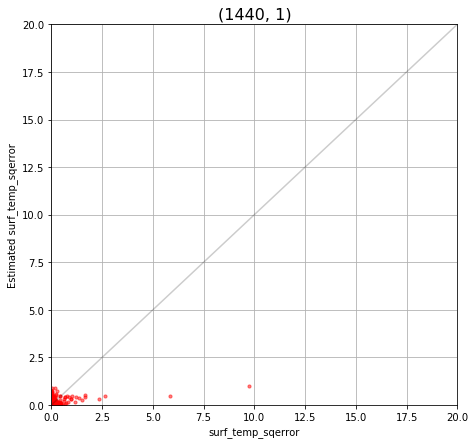

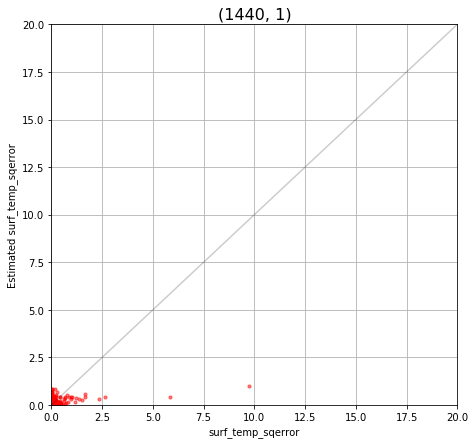

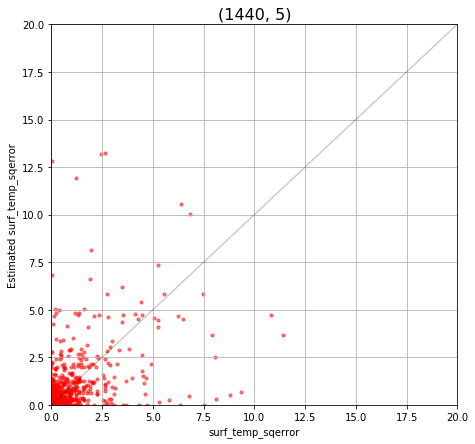

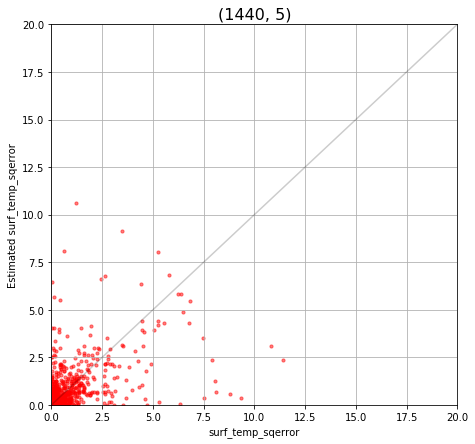

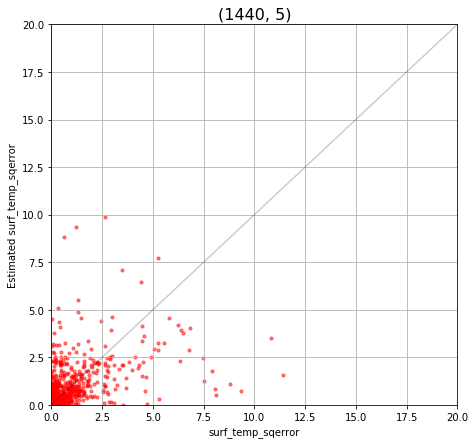

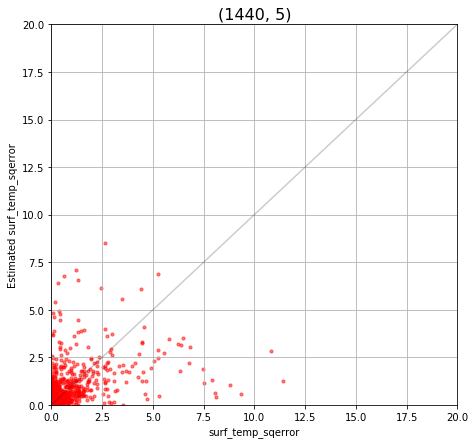

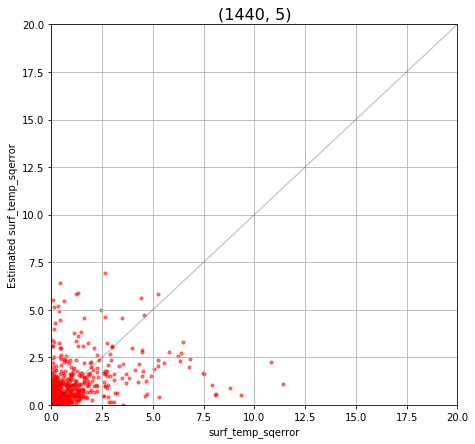

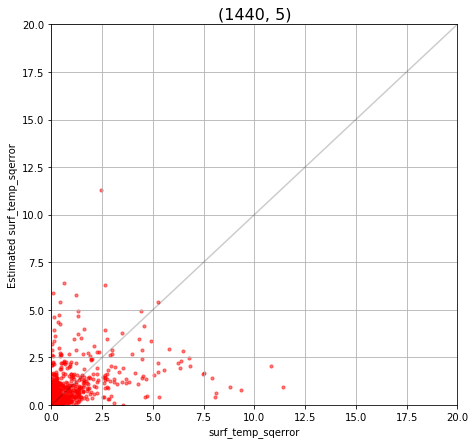

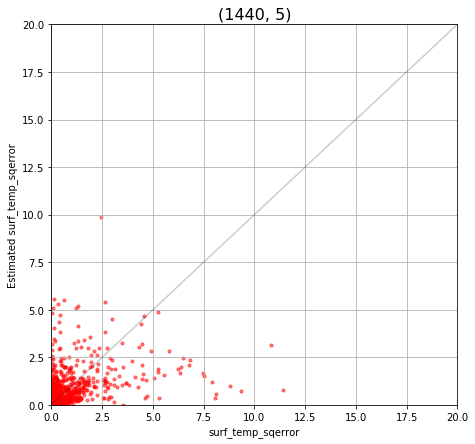

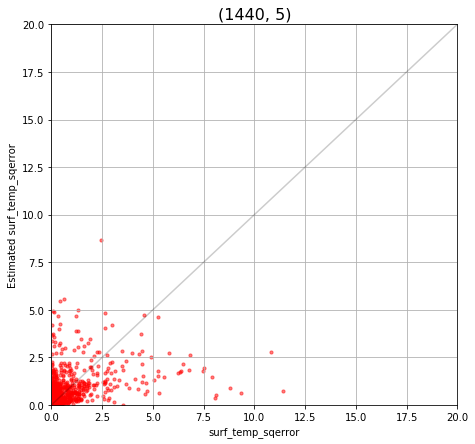

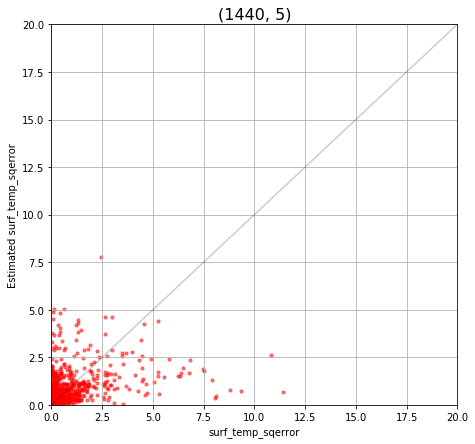

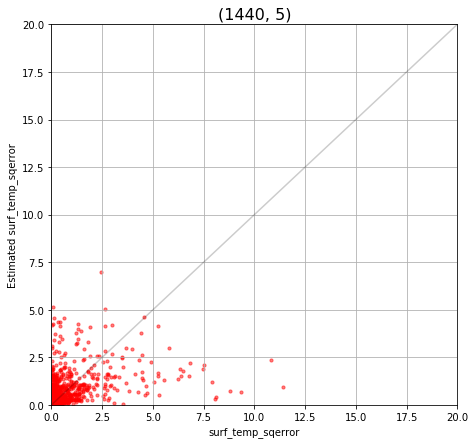

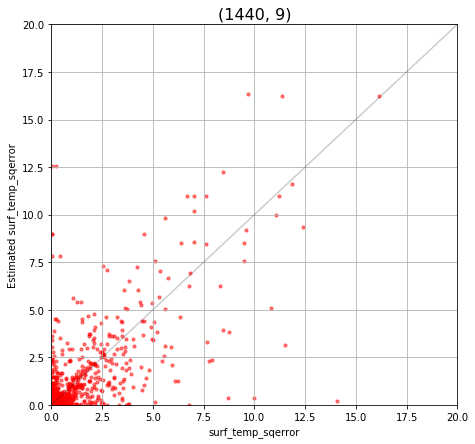

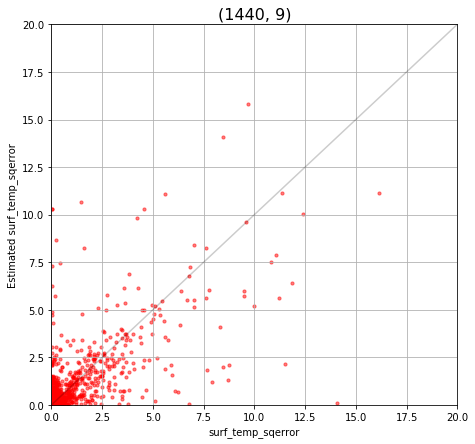

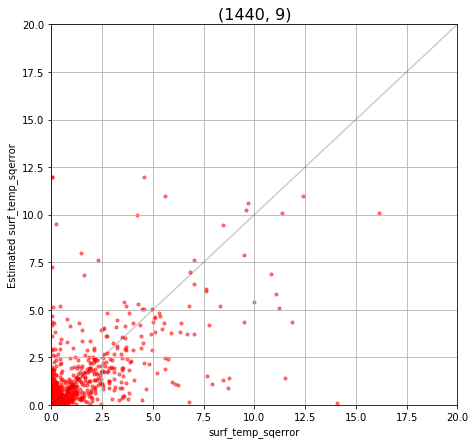

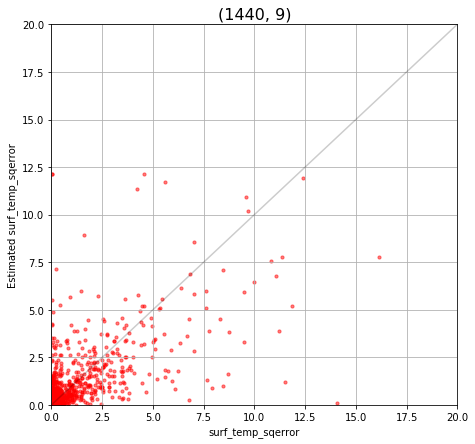

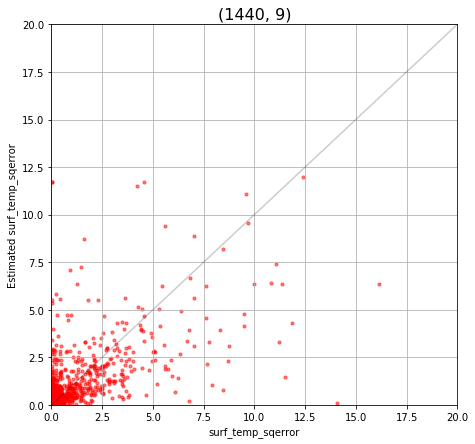

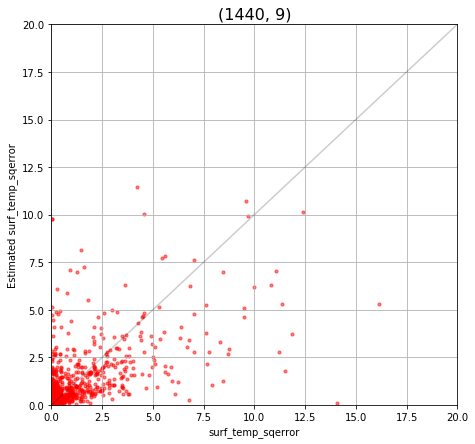

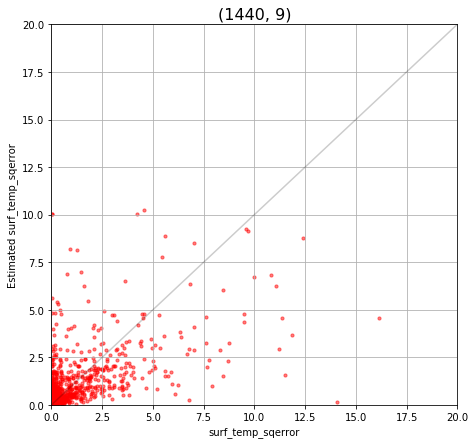

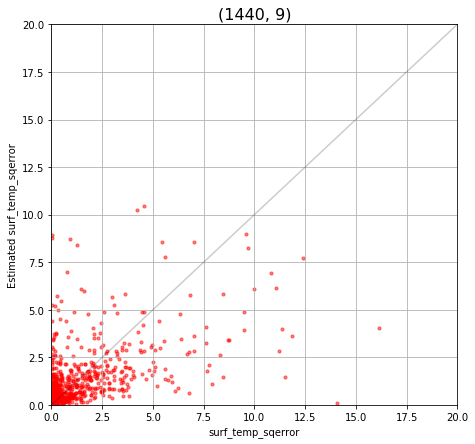

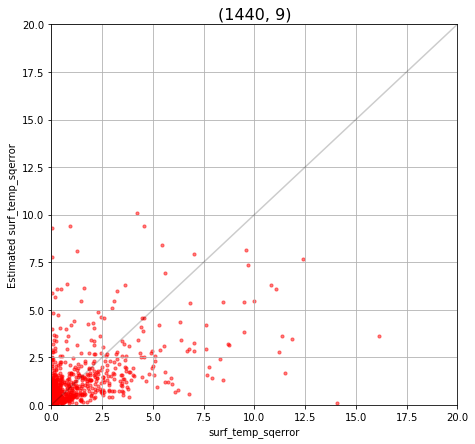

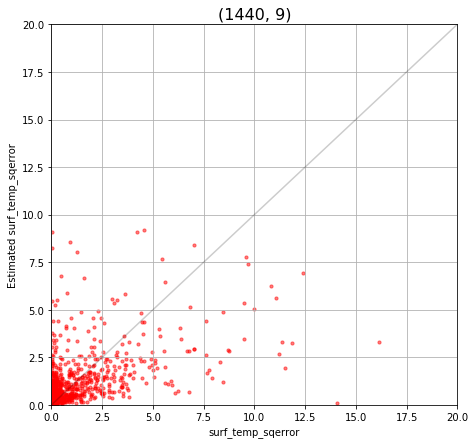

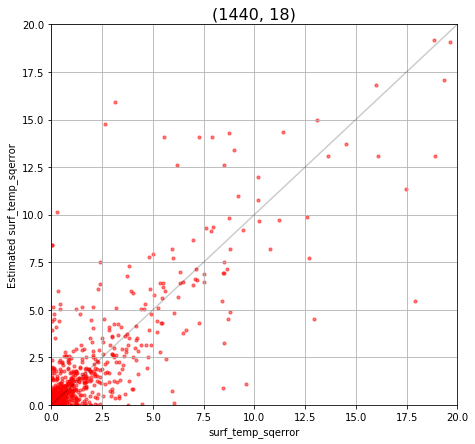

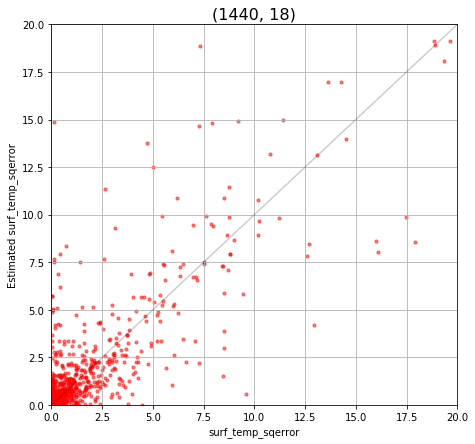

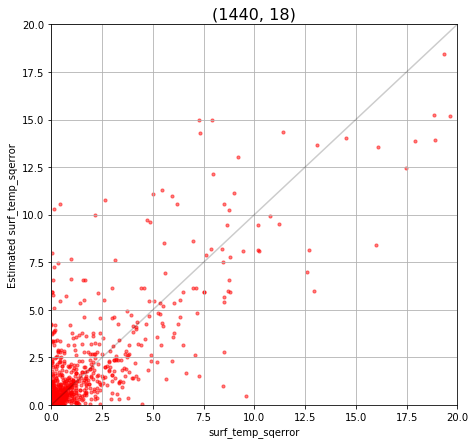

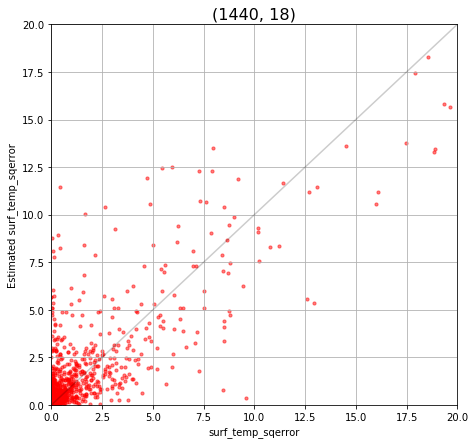

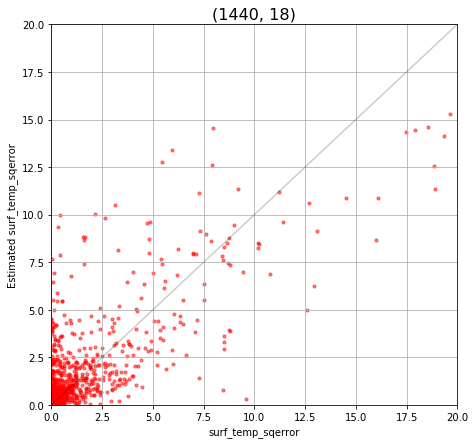

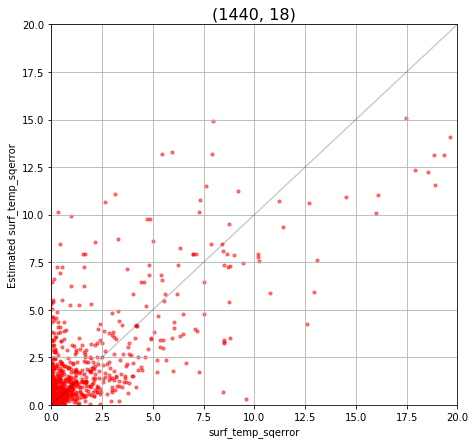

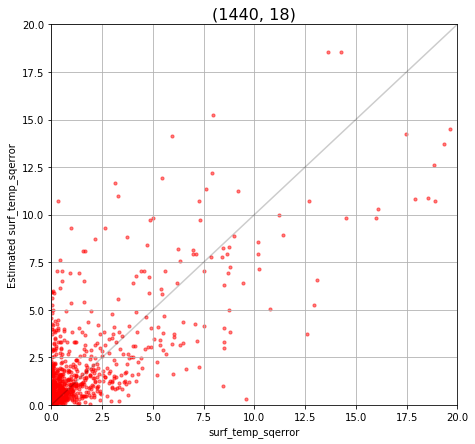

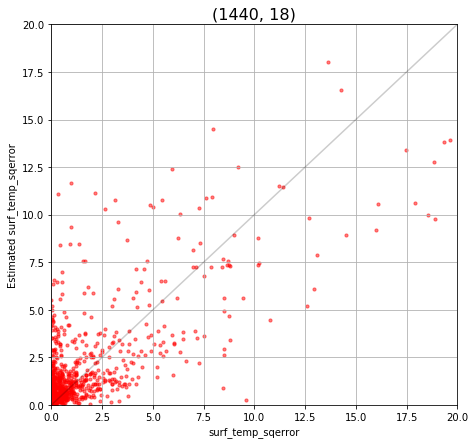

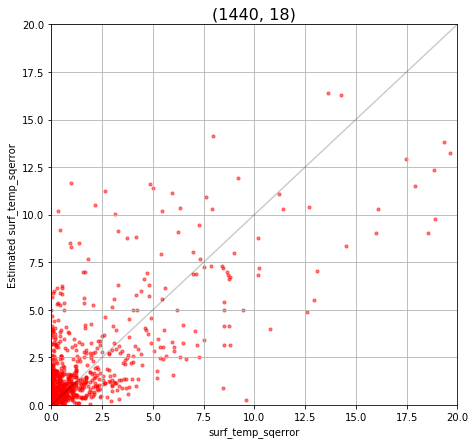

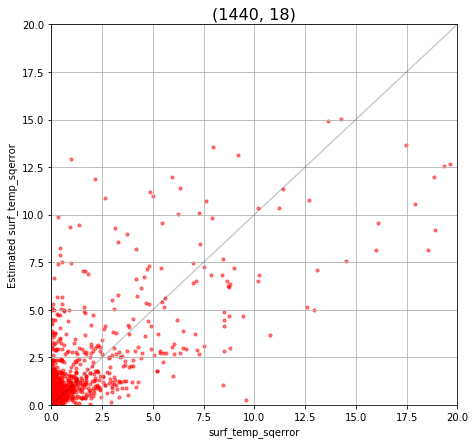

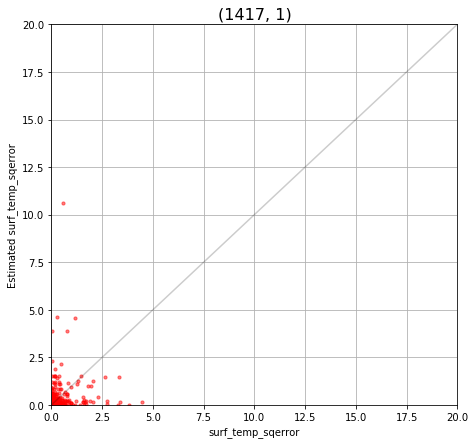

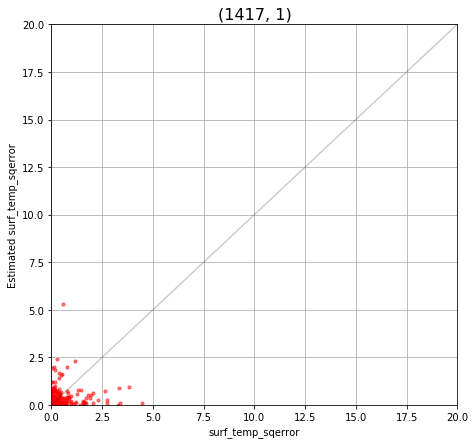

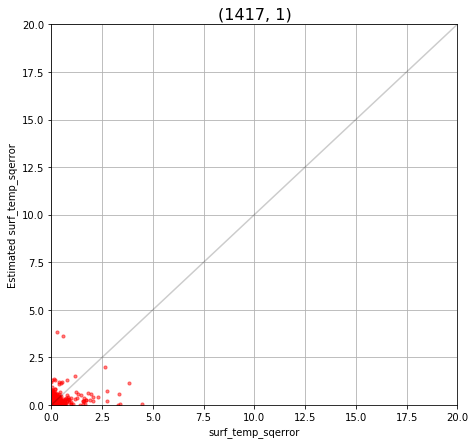

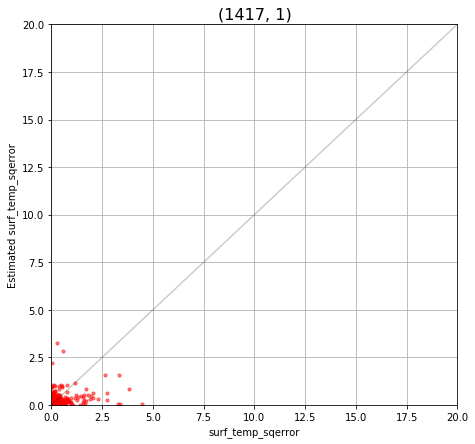

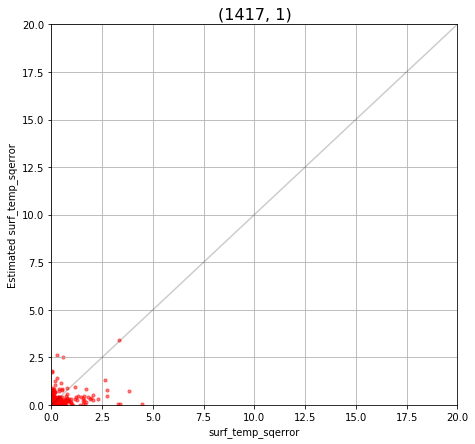

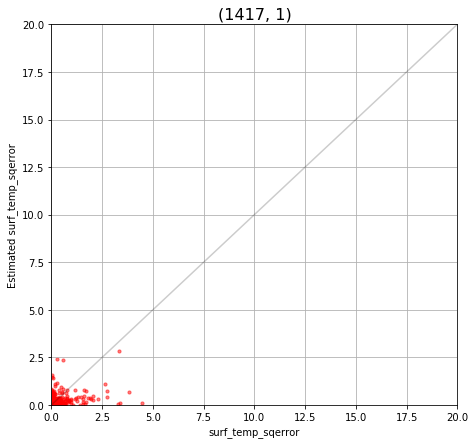

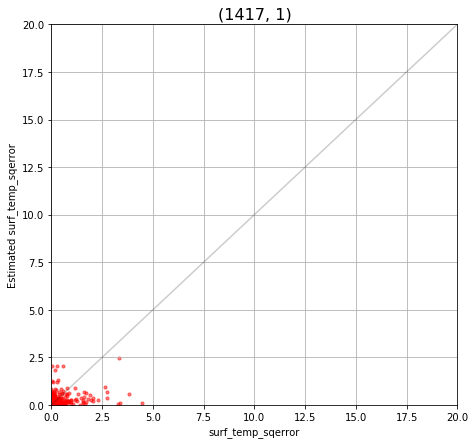

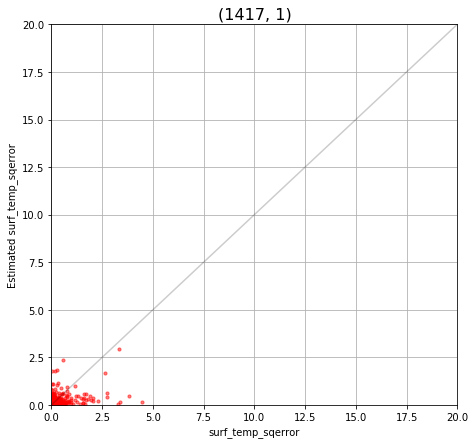

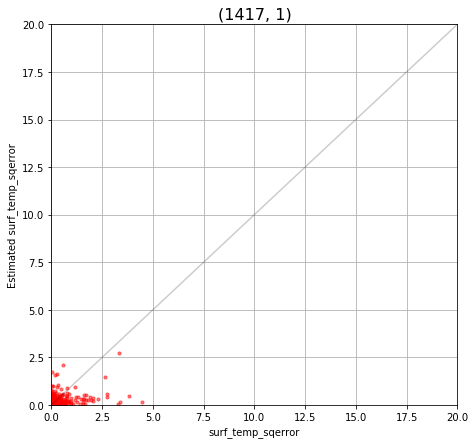

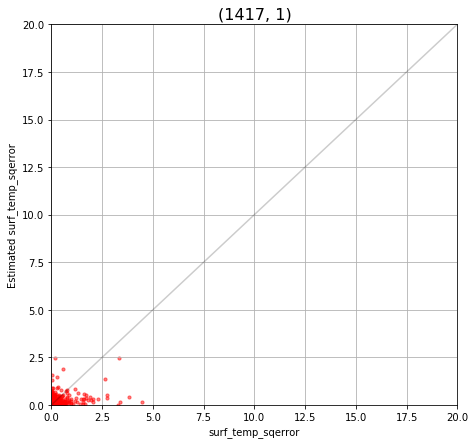

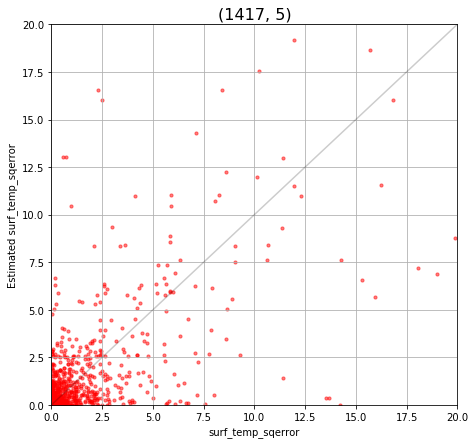

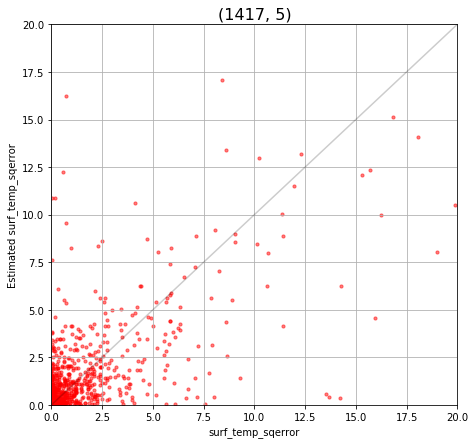

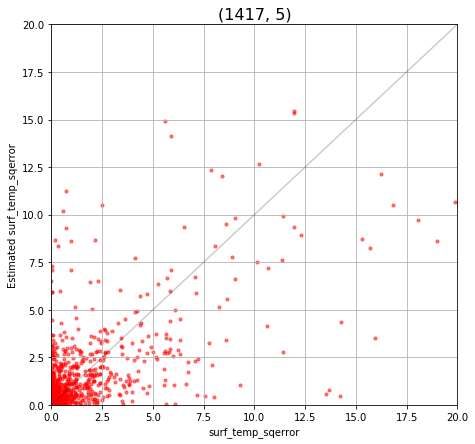

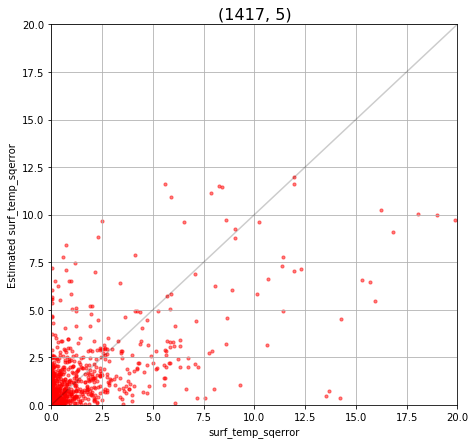

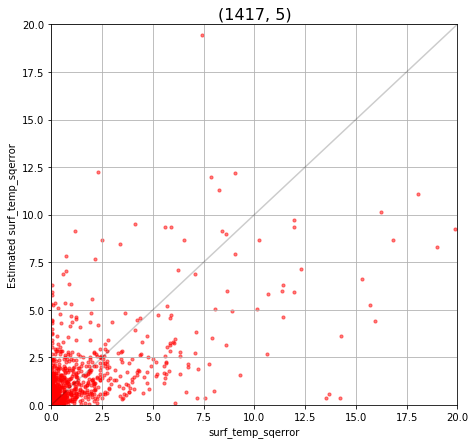

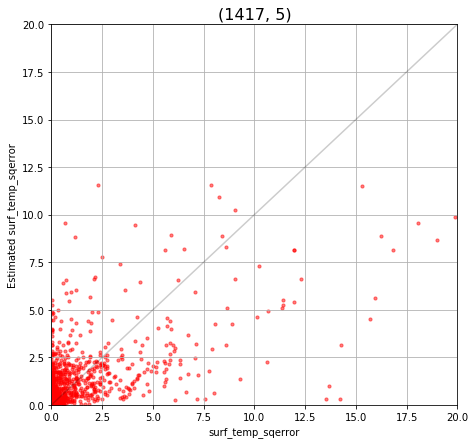

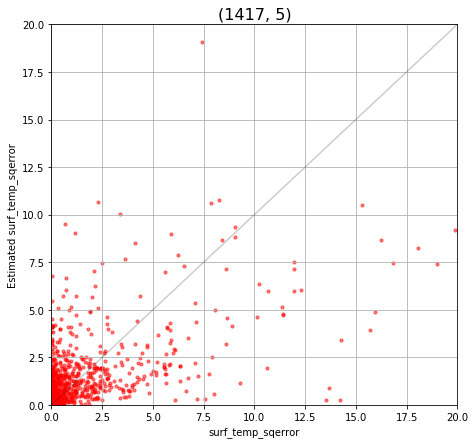

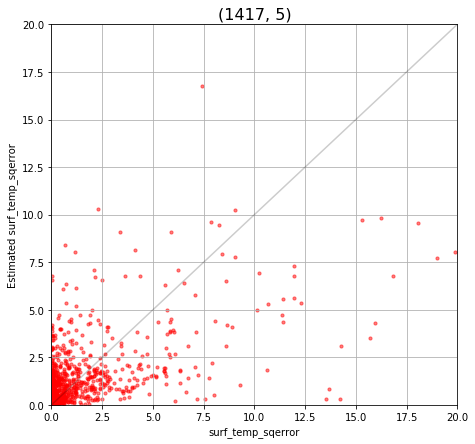

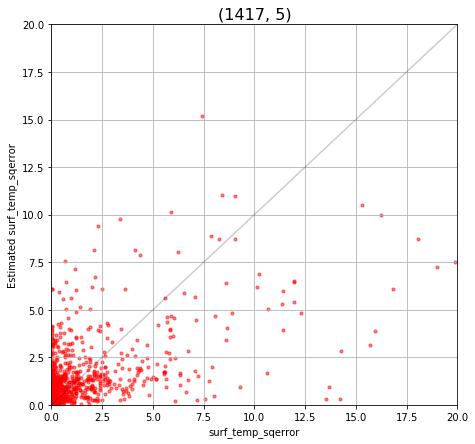

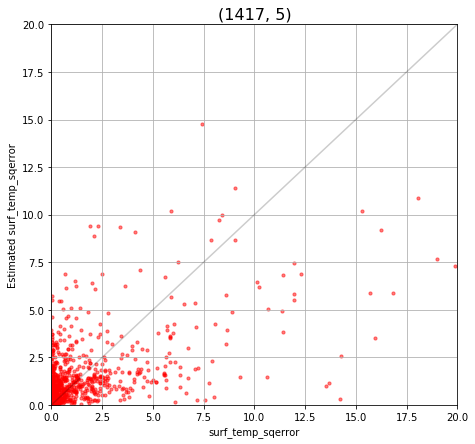

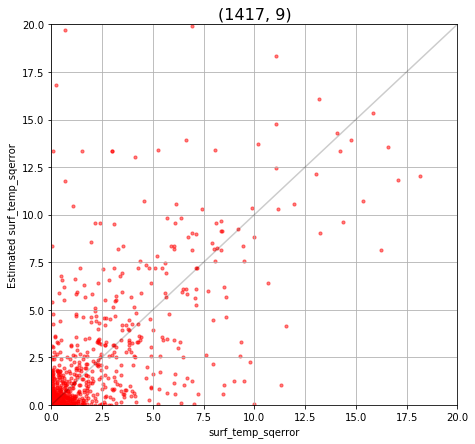

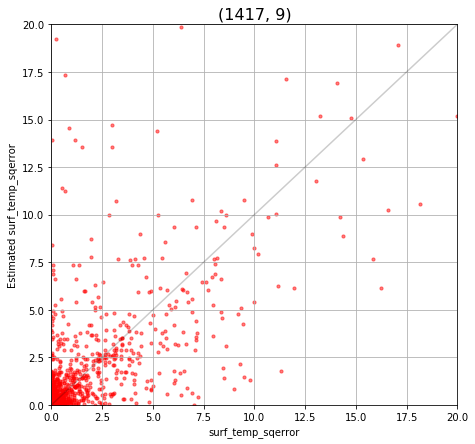

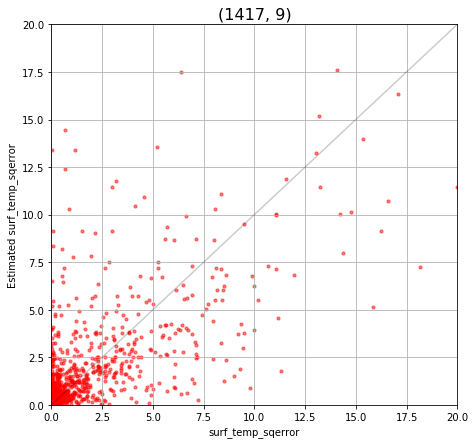

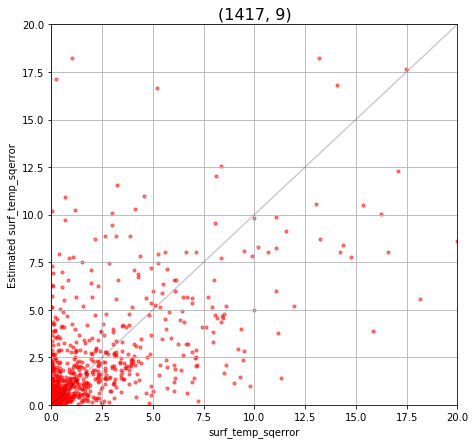

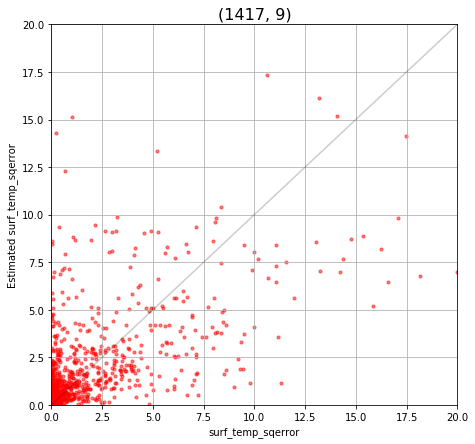

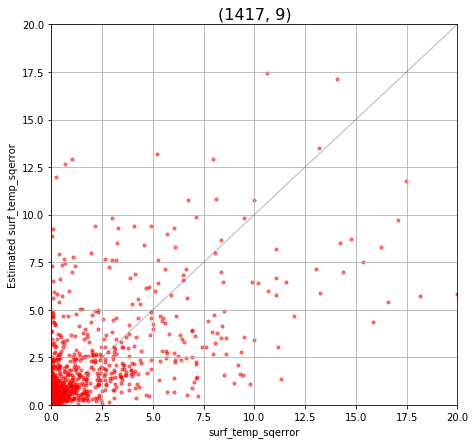

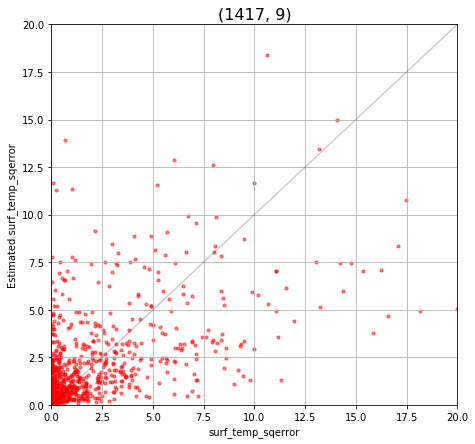

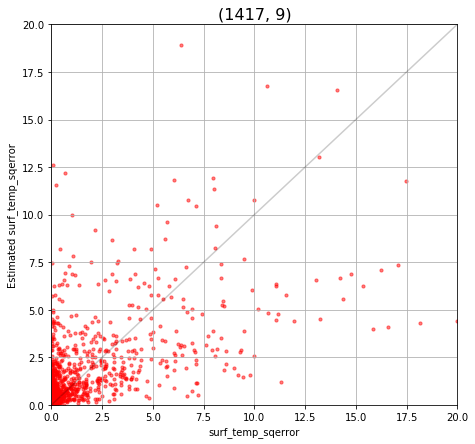

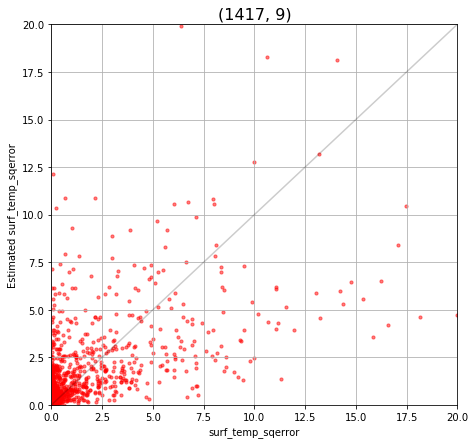

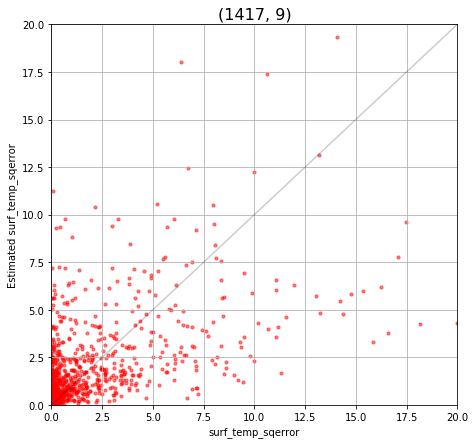

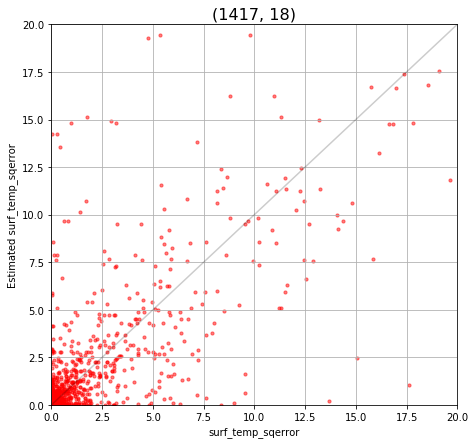

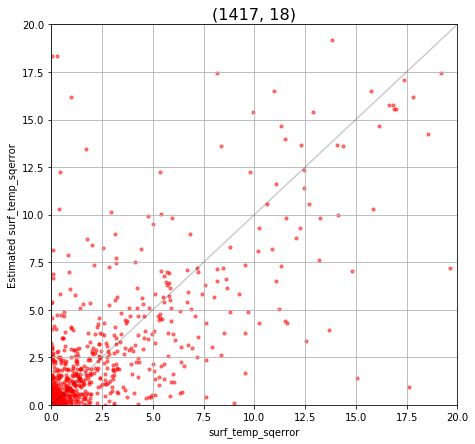

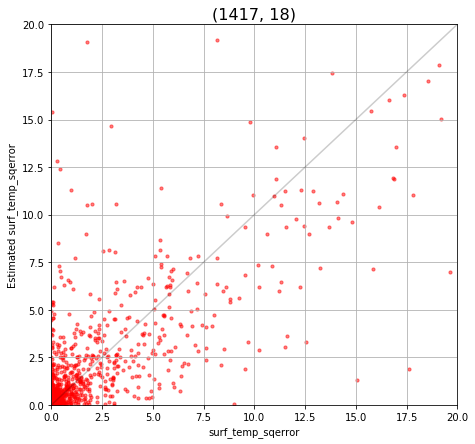

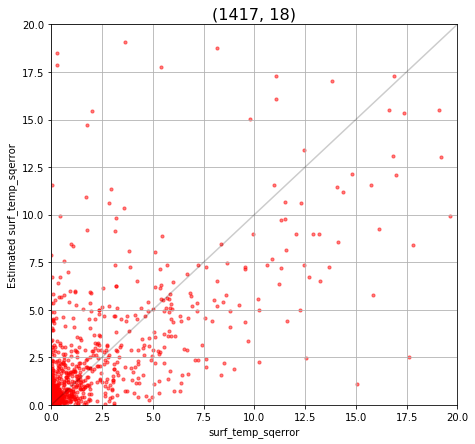

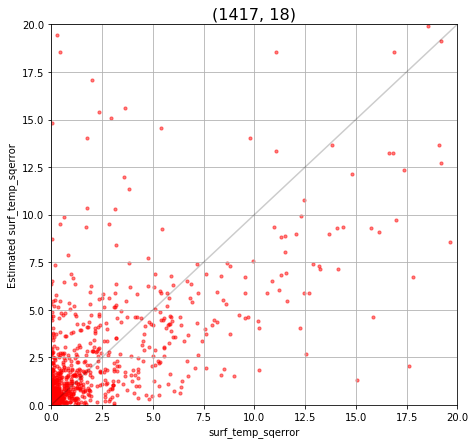

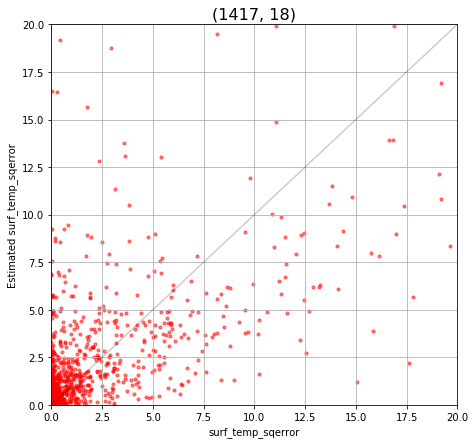

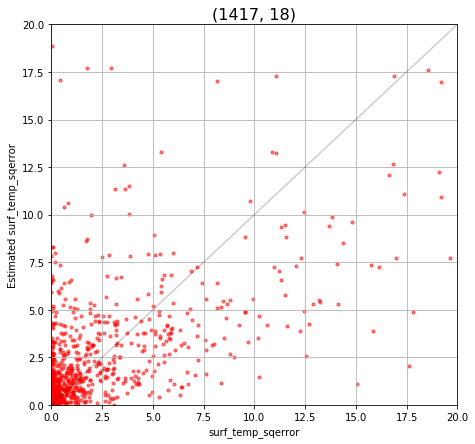

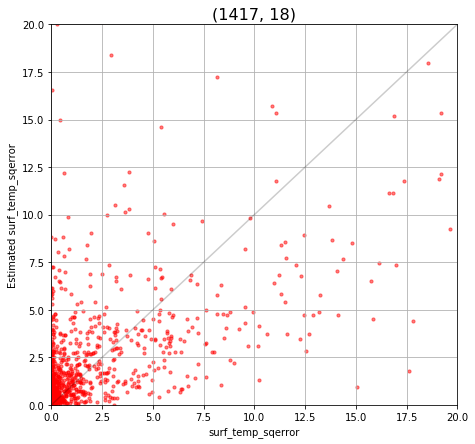

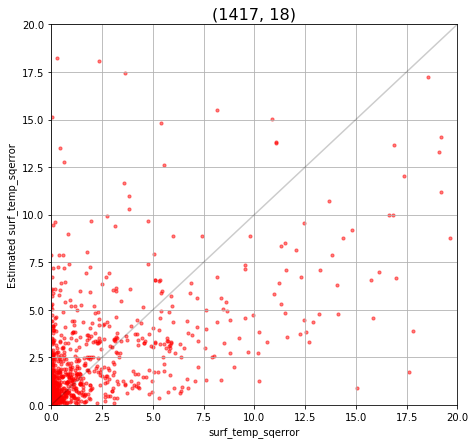

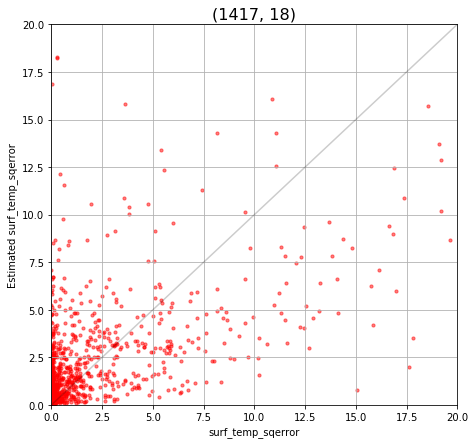

In [11]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

repeats = 10
features = 1
results = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        results[key] = experiment(repeats, df[key], key)
    

In [13]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/knn/results_{}.csv".format(str(key)))

    with open("results/knn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

In [26]:
df[(1419, 18)].shape

(3141, 25)